# Dog or Cat: Image Classification
## Introduction
In this project we will develop deep learning models to classify images of dogs and cats. 

According to Kaggle website, Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task used to be difficult for computers, but studies have shown that people can accomplish it quickly and accurately. However, as we will find out, it is not so hard for deep learning algorithms anymore!

For this fun task we will first create a Convolutional Neural Network (CNN) model and try to classify images of cats and dogs, later we will try transfer learning with ResNet to see if we can improve. 

## Data Set Overview
The data set is available at: https://www.kaggle.com/competitions/dogs-vs-cats/data

The training set contains 25000 images of dogs or cats. Label 0 indicates a cat and label 1 indicates a dog. 

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle offers a subset of this data. 


## Loading Necessary Libraries
We will start by importing the libraries we will need.

In [87]:
import os
from os import makedirs
from os import listdir
import cv2
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.models import Model
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam

from warnings import filterwarnings
filterwarnings(action='ignore')

## Loading data
We will load in the data and create our training data frame.

In [2]:
filenames = os.listdir("train/")
labels = [x.split(".")[0] for x in filenames]

train_df = pd.DataFrame({"filename": filenames, "label": labels})

train_df.head()

filename label
0   dog.8011.jpg   dog
1   cat.5077.jpg   cat
2   dog.7322.jpg   dog
3   cat.2718.jpg   cat
4  cat.10151.jpg   cat

## Exploratory Data Analysis
Let's explore some of the dog pictures in our data set:

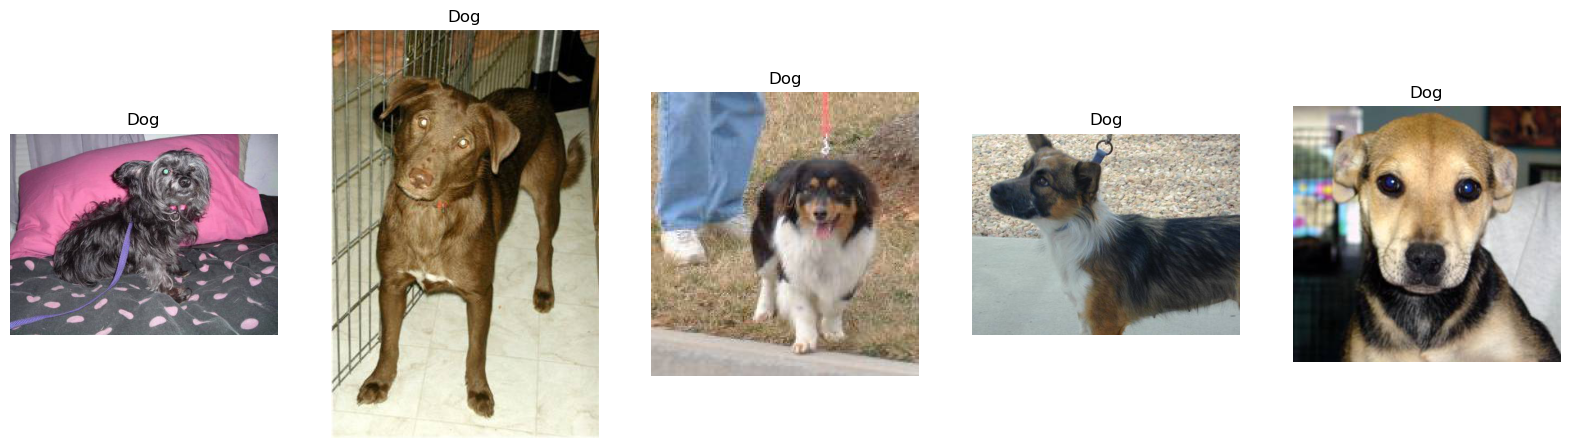

In [3]:
plt.figure(figsize= (20, 30)) 

for i in range(5):
    
    plt.subplot(2, 5, i+1)   
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog')
    plt.axis('off')

plt.show()

Now let's take a look at some of the cat pictures in our data set:

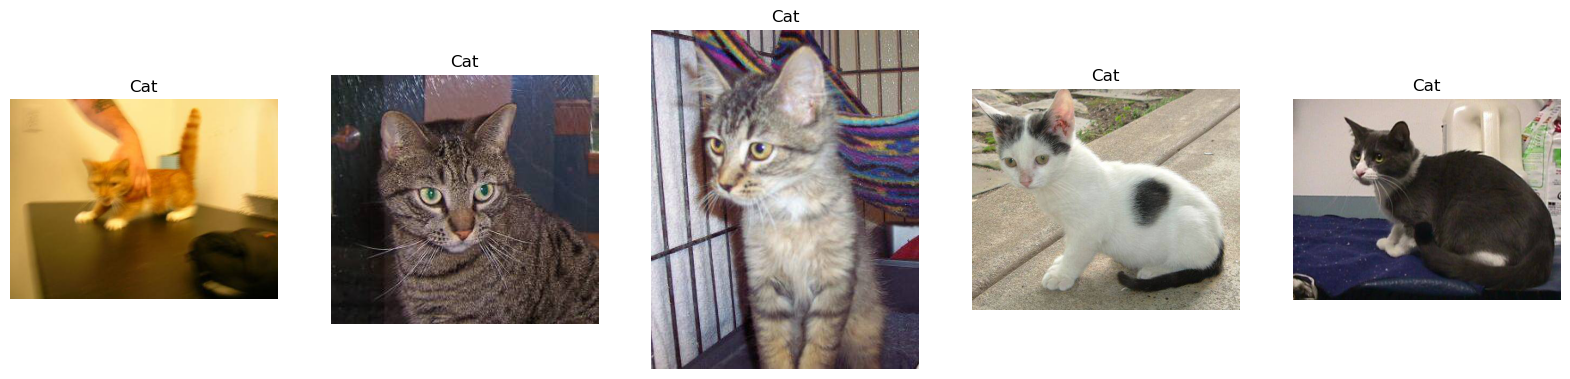

In [4]:
plt.figure(figsize=(20,30))

for i in range(5):
    
    plt.subplot(1,5, i+1)   
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat')
    plt.axis('off')

plt.show()

As we can see in the example above, images are of different sizes. 

### Distribution of cat and dog images in our data:

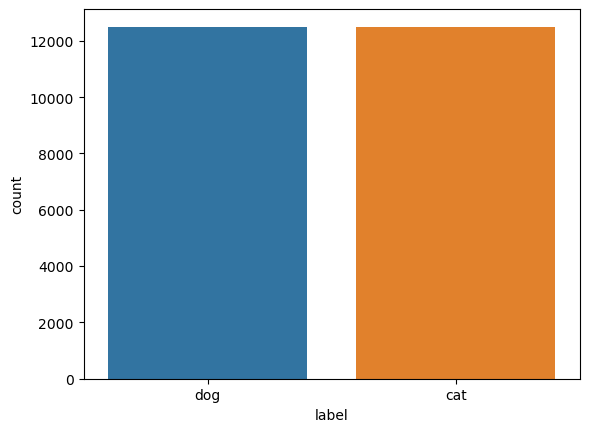

In [5]:
sns.countplot(data = train_df, x= train_df['label']);

Let's take a look at individual images' characteristics:

In [6]:
def get_dims (img):
    image = cv2.imread(img)
    h, w, d = image.shape
    return h, w , d

In [7]:
df = pd.DataFrame(columns = ['Height',
                            'Width',
                            'Channels',
                            'Class'])
for img in filenames:
    h, w, d = get_dims('train'+'/'+img)
    df.loc[len(df)] = [h , w , d, img.split('.')[0]]
    
df

Height  Width  Channels Class
0         500    380         3   dog
1         300    399         3   cat
2         120    159         3   dog
3         480    467         3   cat
4         375    499         3   cat
...       ...    ...       ...   ...
24995     350    249         3   dog
24996     375    499         3   dog
24997     500    475         3   dog
24998     296    500         3   cat
24999     375    499         3   cat

[25000 rows x 4 columns]

For dog we predict 1 and for cat 0, so we will add category column to our data. 

In [8]:
train_df['category'] = train_df['label'].apply(lambda x: 0 if x == 'cat' else 1)
train_df.head()

filename label  category
0   dog.8011.jpg   dog         1
1   cat.5077.jpg   cat         0
2   dog.7322.jpg   dog         1
3   cat.2718.jpg   cat         0
4  cat.10151.jpg   cat         0

## Data Preparation
We will split our data into training, validation and testing sets.

In [9]:

train, val_test = train_test_split(train_df , test_size = 0.2, stratify = train_df['label'], random_state = 42)

val, test = train_test_split(val_test, test_size = 0.5, stratify = val_test['label'], random_state = 42)

train = train.reset_index(drop = True)
val = val.reset_index(drop = True)
test = test.reset_index(drop=True)


In [10]:
train.shape , val.shape, test.shape

((20000, 3), (2500, 3), (2500, 3))

We will set the parameters for generating training data with flow_from_dataframe

In [81]:
image_l = 128
image_size = (image_l , image_l)
image_channel = 3

batch_size  = 15

We will **augment** our data using ImageDataGenerator, using zoom_range, shear_range, rotation_range etc. parameters. We also normalize using rescale parameter, dividing by 255. 

In [82]:
train_dategen = ImageDataGenerator(rotation_range = 15 , 
                                  rescale = 1.0/255 ,
                                  shear_range = 0.1,
                                  zoom_range = 0.2 , 
                                  horizontal_flip = True , 
                                  width_shift_range = 0.1 , 
                                  height_shift_range = 0.1
                                  )


Now we can generate our train, validation and test sets with flow_from_dataframe.

In [83]:
train_generator = train_dategen.flow_from_dataframe(
    train, 
    "train", 
    x_col='filename',
    y_col='label',
    target_size = image_size,
    class_mode = 'categorical',
    batch_size = batch_size
)  


Found 20000 validated image filenames belonging to 2 classes.


In [84]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = validation_datagen.flow_from_dataframe(
    val, 
    "train", 
    x_col = 'filename',
    y_col = 'label',
    target_size = image_size,
    class_mode = 'categorical',
    batch_size = batch_size
)  


Found 2500 validated image filenames belonging to 2 classes.


In [85]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test, 
    "train" ,
    x_col = 'filename',
    y_col = 'label',
    target_size= image_size,
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False
    )


Found 2500 validated image filenames belonging to 2 classes.


## First CNN Model
We are ready to develop our first model.

Convolutional Neural Network (CNN) is a Deep Learning neural network architecture commonly used in image classification. 

CNNs consist of multiple layers like the input layer, convolutional layer, pooling layer and fully connected layers. Here is an image of a generalized architecture of a CNN from geeksforgeeks:

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20231218174301/max.png">

Our CNN Model architecture consists of following layers:
* Input Layer with relu activation
* 3 Convolutional Layers with Batch Normalization, MaxPooling and Dropout
* Fully Connected layer with Flatten Layer, Dense Layer and Dropout
* Output Layer with Dense Layer with softmax activation


In [88]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_l, image_l, image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,514 (19.50 MB)

 Trainable params: 5,110,530 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

We will define two callbacks, EarlyStopping and ReduceLROnPlateau. 
We will stop training early when validation loss stops improving. 

In [89]:
early_stoping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True, verbose=1)

We will reduce learning rate when validation accuracy stops improving. 

In [90]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

We will compile out model with adam as optimizer, binary crossentropy loss and accuracy metric. 

In [91]:
model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])

We will train our model with the training data. 

In [92]:
cat_dog = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[early_stoping, learning_rate_reduction],
                    epochs = 20)

Epoch 1/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 75s 49ms/step - accuracy: 0.6161 - loss: 0.7482 - val_accuracy: 0.6896 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 2/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 61s 45ms/step - accuracy: 0.7365 - loss: 0.5347 - val_accuracy: 0.7652 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 3/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - accuracy: 0.7856 - loss: 0.4651 - val_accuracy: 0.7228 - val_loss: 0.5736 - learning_rate: 0.0010
Epoch 4/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 62s 46ms/step - accuracy: 0.8329 - loss: 0.3868 - val_accuracy: 0.8008 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 5/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - accuracy: 0.8424 - loss: 0.3595 - val_accuracy: 0.6956 - val_loss: 0.7441 - learning_rate: 0.0010
Epoch 6/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - accuracy: 0.8481 - loss: 0.3417 - val_accuracy: 0.8756 - val_loss: 0.2976 - learning_rate: 0.0010
Epoch 7/20
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 61s 45ms/step - accura

## Accuracy and Loss Plots for first CNN Model
We will plot accuracy and loss per epoch of training and validation sets for our first CNN model. 

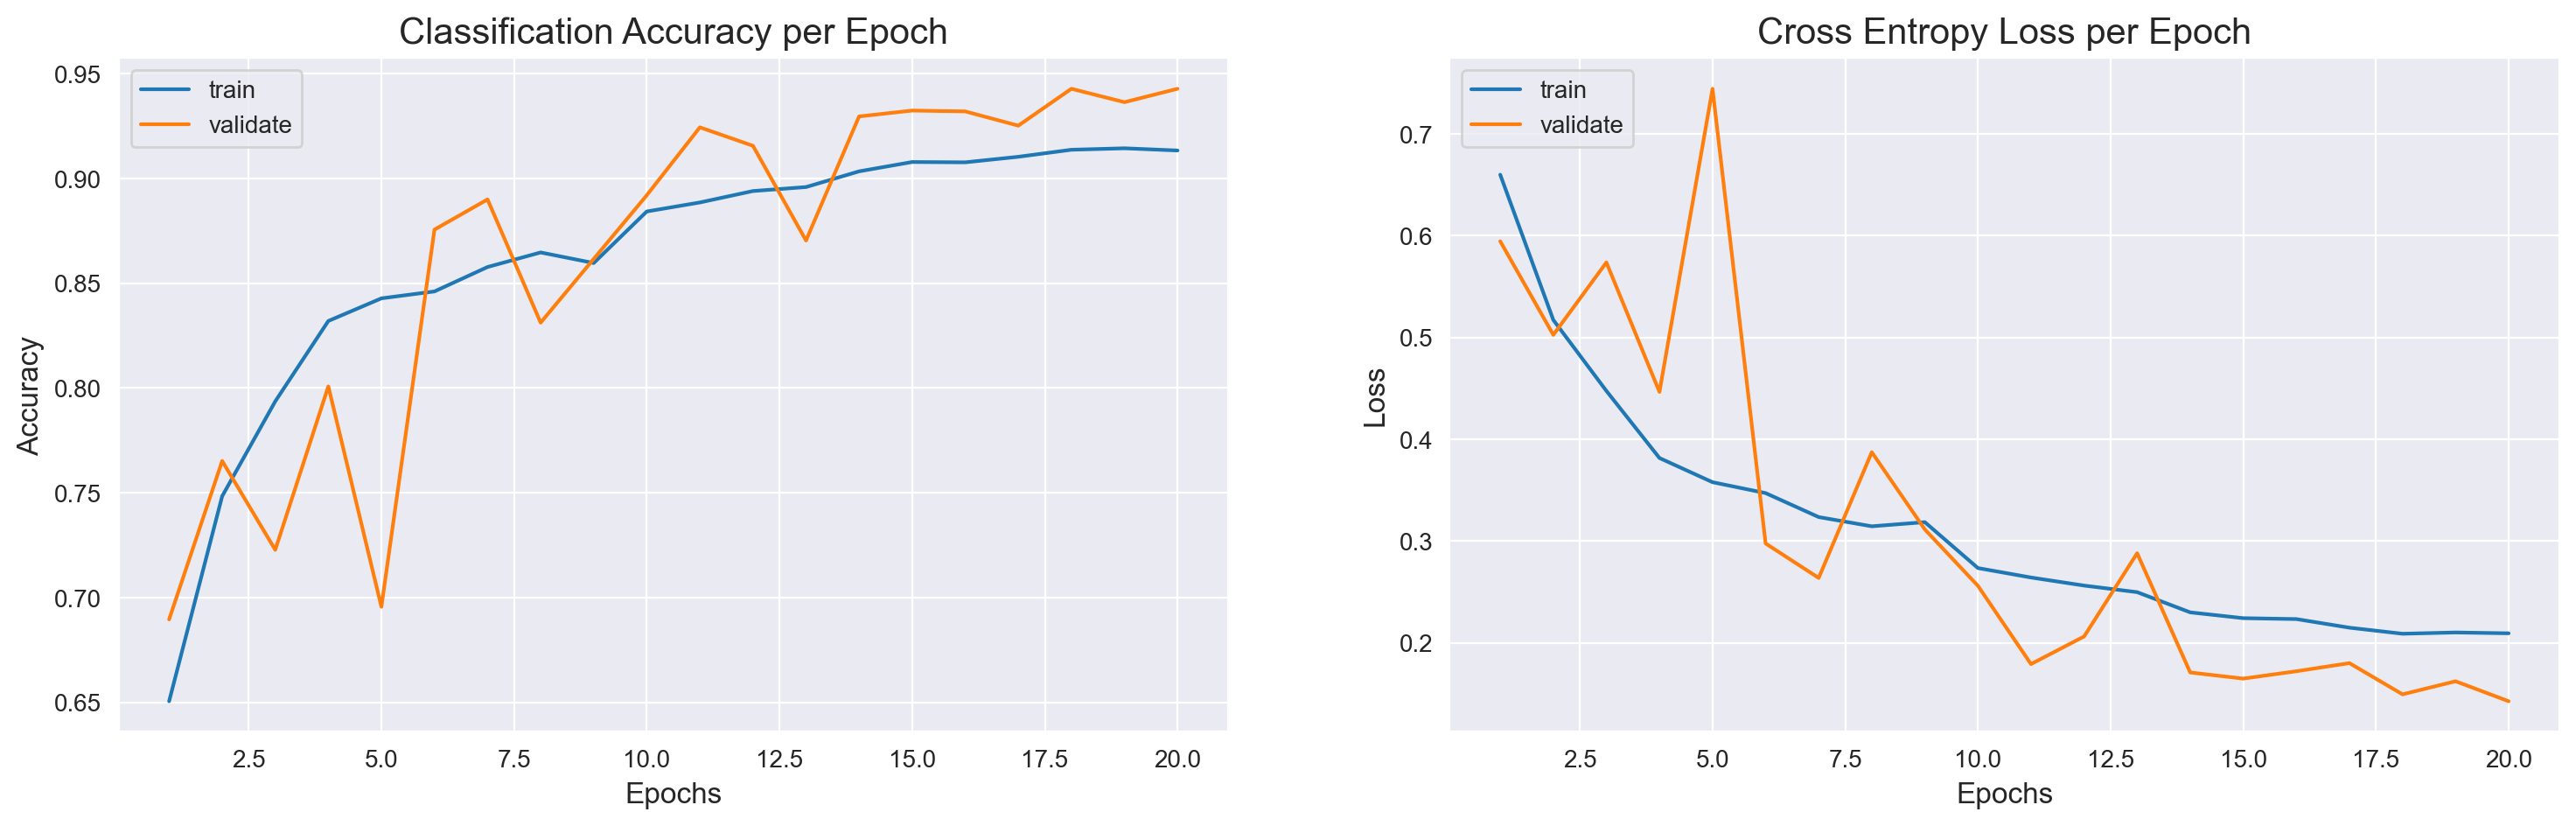

In [93]:
plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(1, 2, 1)
plt.title('Classification Accuracy per Epoch',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(np.arange(1,len(cat_dog.history['accuracy']) + 1), cat_dog.history['accuracy'])
plt.plot(np.arange(1,len(cat_dog.history['val_accuracy']) + 1), cat_dog.history['val_accuracy'])
plt.legend(['train', 'validate'], loc='upper left')

plt.subplot(1, 2, 2)
plt.title('Cross Entropy Loss per Epoch',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(np.arange(1,len(cat_dog.history['loss']) + 1), cat_dog.history['loss'])
plt.plot(np.arange(1,len(cat_dog.history['val_loss']) + 1), cat_dog.history['val_loss'])
plt.legend(['train', 'validate'], loc='upper left')

plt.show()

We get over 0.9 accuracy on our validation set with our first CNN model. 

## Hyperparameter Tuning
Now we will employ hyperparameter tuning on our CNN Model to see if we can improve on it. 

First we define the create_model function with different number of units to try for each layer, range of dropout rates to try and range of learning rates to try. 

In [107]:
def create_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_units', min_value=32, max_value=64, step=32), (3, 3), activation='relu', input_shape=(image_l, image_l, image_channel)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Choice('dropout', [0.2, 0.5])),
        
        Conv2D(hp.Int('conv2_units', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Choice('dropout', [0.2, 0.5])),

        Conv2D(hp.Int('conv3_units', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Choice('dropout', [0.2, 0.5])),

        Conv2D(hp.Int('conv4_units', min_value=128, max_value=256, step=128), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(hp.Choice('dropout', [0.2, 0.5])),
                
        Flatten(),
        Dense(hp.Int('dense_units', min_value=256, max_value=512, step=256), activation='relu'),
        Dropout(hp.Choice('dropout', [0.2, 0.5])),
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

We will use RandomSearch from keras for hyperparameter tuning.

In [108]:
model_hp = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=15
)

We start the search for the hyperparameters. We try for 10 epochs for each trial for time saving purposes. We also employ early stopping.

In [109]:
model_hp.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Trial 15 Complete [00h 04m 30s]
val_accuracy: 0.5324000120162964

Best val_accuracy So Far: 0.8967999815940857
Total elapsed time: 01h 45m 26s


In [110]:
best_model = model_hp.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,769,858 (10.57 MB)

 Trainable params: 2,768,834 (10.56 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [111]:
model_hp.oracle.get_best_trials(num_trials=1)[0].summary()

Trial 10 summary
Hyperparameters:
conv1_units: 64
dropout: 0.2
conv2_units: 64
conv3_units: 128
conv4_units: 256
dense_units: 256
learning_rate: 0.001
Score: 0.8967999815940857


The best model in our hyperparameter search is not better than our original CNN model. Limited number of trials and epochs with RandomSearch might have prevented us to get to the best possible parameters. We will continue on with transfer learning.

## Transfer Learning with ResNet

ResNet50 is a pretrained Convolutional Neural Network that is 50 layers deep and is trained on more than a million images from the ImageNet database. ResNet solved the vanishing gradient problem using Residual Blocks that allow for the direct flow of information through the skip connections.

We will try to harness the power of ResNet for our cat or dog classification problem via transfer learning. We will use ResNet as base and add a couple layers for our problem.

In [112]:
base = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet' , include_top = False , input_shape = (128, 128, 3))


### Customize our model
We will add layers to the ResNet base models for our purposes. We will add GlobalAveragePooling2D layer and Dropout layer and a Dense layer with softmax activation for the output. 

In [113]:
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
resnet_model = Model(inputs = base.input, outputs = predictions)


We will compile our model with adam optimizer and 0.0001 learning rate.

In [114]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet_model.compile(optimizer = opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])

We will take a look at our new ResNet based model architecture, it is huge:

In [115]:
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

We will again use early stopping and learning rate reduction when validation accuracy stops improving

In [116]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop , learning_rate_reduction]

Now we will fit our ResNet based model to our training data. 

In [117]:
resnet_history = resnet_model.fit(
    train_generator, 
    epochs = 7, 
    validation_data = val_generator,
    callbacks = callbacks
)

Epoch 1/7
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1153s 807ms/step - accuracy: 0.8613 - loss: 0.3648 - val_accuracy: 0.9680 - val_loss: 0.0833 - learning_rate: 1.0000e-04
Epoch 2/7
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 878s 657ms/step - accuracy: 0.9514 - loss: 0.1236 - val_accuracy: 0.9636 - val_loss: 0.0897 - learning_rate: 1.0000e-04
Epoch 3/7
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 906s 678ms/step - accuracy: 0.9623 - loss: 0.0996 - val_accuracy: 0.9664 - val_loss: 0.0944 - learning_rate: 1.0000e-04
Epoch 4/7
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1009s 756ms/step - accuracy: 0.9762 - loss: 0.0634 - val_accuracy: 0.9708 - val_loss: 0.0915 - learning_rate: 5.0000e-05
Epoch 5/7
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 907s 679ms/step - accuracy: 0.9792 - loss: 0.0550 - val_accuracy: 0.9732 - val_loss: 0.0678 - learning_rate: 5.0000e-05
Epoch 6/7
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 1117s 837ms/step - accuracy: 0.9832 - loss: 0.0460 - val_accuracy: 0.9772 - val_loss: 0.0650 - learning_rate: 5.0000e-05
Epoch 7/7
1334/1334 ━━━━━━━━━━━

## Accuracy and Loss Plots for ResNet based Model
Here we are going to take a look at training and validation accuracy and loss plots for ResNet based model.

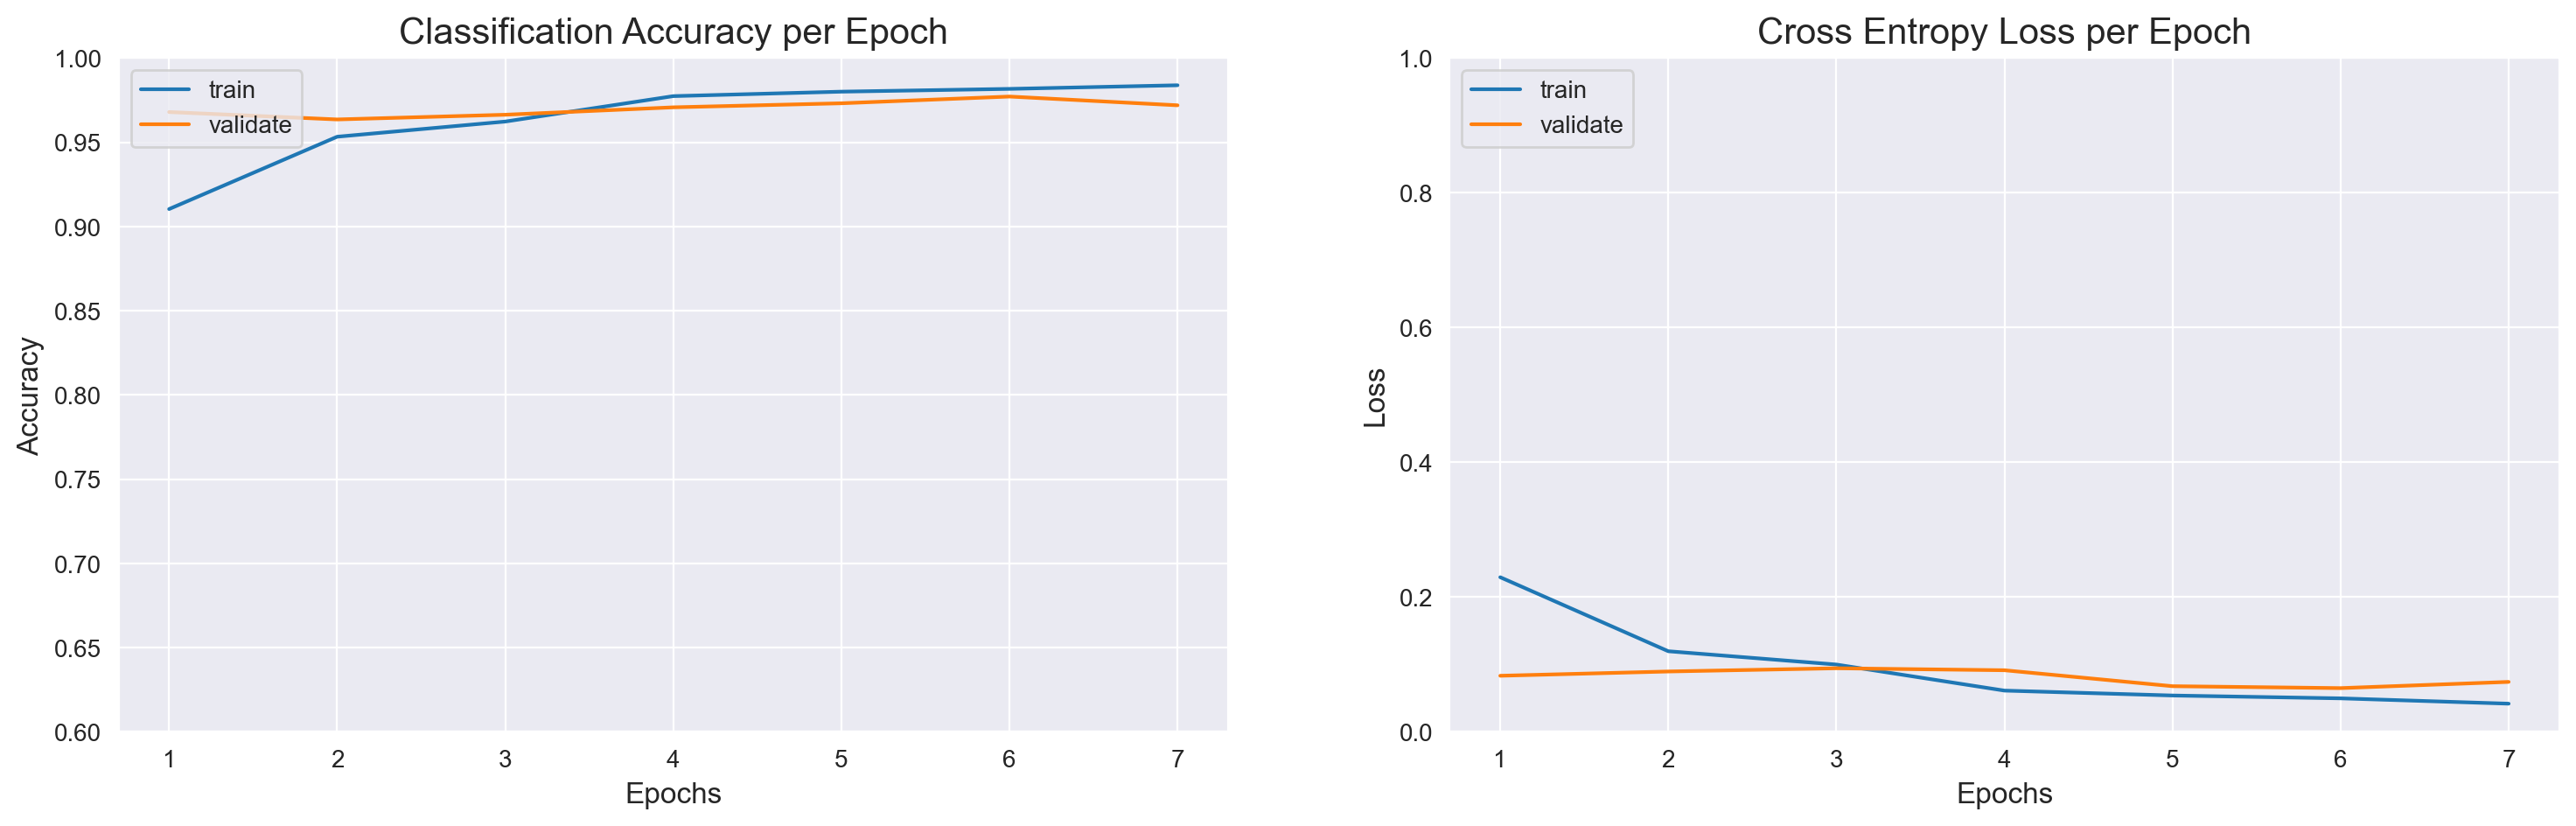

In [118]:
plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(1, 2, 1)
plt.title('Classification Accuracy per Epoch',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.ylim(0.60, 1)
plt.plot(np.arange(1,len(resnet_history.history['accuracy']) + 1), resnet_history.history['accuracy'])
plt.plot(np.arange(1,len(resnet_history.history['val_accuracy']) + 1), resnet_history.history['val_accuracy'])
plt.legend(['train', 'validate'], loc='upper left')

plt.subplot(1, 2, 2)
plt.title('Cross Entropy Loss per Epoch',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.ylim(0, 1)
plt.plot(np.arange(1,len(resnet_history.history['loss']) + 1), resnet_history.history['loss'])
plt.plot(np.arange(1,len(resnet_history.history['val_loss']) + 1), resnet_history.history['val_loss'])
plt.legend(['train', 'validate'], loc='upper left')

plt.show()

The accuracy of our ResNet based model looks impressive from the start, much better than our first CNN model.

## Results
Now we will predict labels for our test set using our first CNN model and ResNet based model.

Let's see which one gets cats and dogs straightened out better!

### Prediction and Results of our first Model 

In [119]:
# true label valuse
y_true = test_generator.labels

# predict with first Model
result = model.predict(test_generator, batch_size = batch_size)

y_pred = np.argmax(result, axis = 1)

# Evaluvate
loss, acc = model.evaluate(test_generator)

print('Test accuracy :', acc*100)
print('Test Loss:', loss)

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9386 - loss: 0.1549
Test accuracy : 94.52000260353088
Test Loss: 0.1447988897562027


In [120]:
print(classification_report(y_true, y_pred, target_names = ['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.94      0.95      0.95      1250
         Dog       0.95      0.94      0.94      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



Test accuracy is 0.95. Very good!

Let's take a look at misclassified images from our first CNN model:

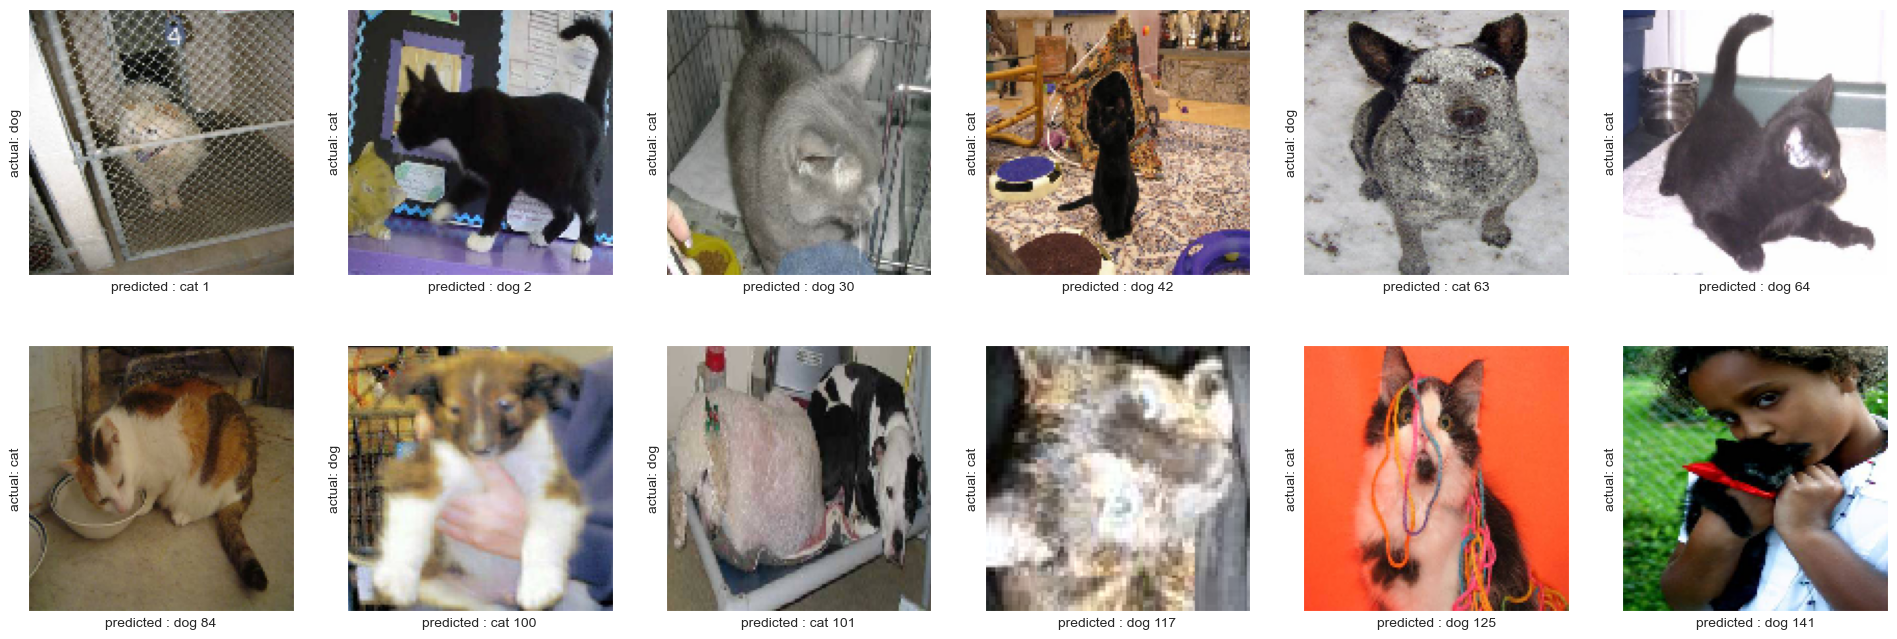

In [121]:
labeldic = {}
for key,value in  test_generator.class_indices.items():
    labeldic[value] = key

#Boolean of misclassified , True = misclassified
A = (y_pred!=y_true)
miscl = np.where(A)
miscl = miscl[0]

#Getting Batch id and Imno in Batch
batchid = []
for x in miscl : 
  i = int(x/batch_size)
  n = x%batch_size
  batchid.append((i,n,x)) 


def plotmis(image,acl,prl,idx):
  plt.imshow(image)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.xlabel('predicted : ' + prl + " " + str(idx))
  plt.ylabel('actual: ' + acl )
    
fig = plt.gcf()
fig.set_size_inches(6 * 4, 2 * 4)

for i, mis in enumerate(batchid):
    batch = mis[0]
    imno = mis[1]
    idx = mis[2]
    image = test_generator[batch][0][imno]
    aclabel = labeldic[y_true[idx]]
    prelabel = labeldic[y_pred[idx]]
    ax = plt.subplot(2,6,i+1)
    plotmis(image,aclabel,prelabel,idx)
    if i > 10:
        break

Unclear images, images with objects or hands in front of them, along with many black cats were misclassified. 

### Prediction and Results of our ResNet based Model

In [122]:
# predict with ResNet based Model
pred_res = resnet_model.predict(test_generator, batch_size = batch_size)

y_pred_res = np.argmax(pred_res, axis = -1)
y_true = test_generator.labels

loss, acc = resnet_model.evaluate(test_generator)


167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9742 - loss: 0.0735


In [123]:
print('ResNet based Model Test accuracy :', acc*100)
print('ResNet based Model Test Loss:', loss)

ResNet based Model Test accuracy : 97.51999974250793
ResNet based Model Test Loss: 0.07601036876440048


Test accuracy for ResNet based model is 97.5. Even better than our CNN model.

In [125]:
print(classification_report(y_true, y_pred_res, target_names = ['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.98      0.97      0.98      1250
         Dog       0.97      0.98      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



Scores for our ResNet based model are impressive 0.98 f1 score, 0.98 accuracy!

Let's take a look at misclassified images from ResNet based model:

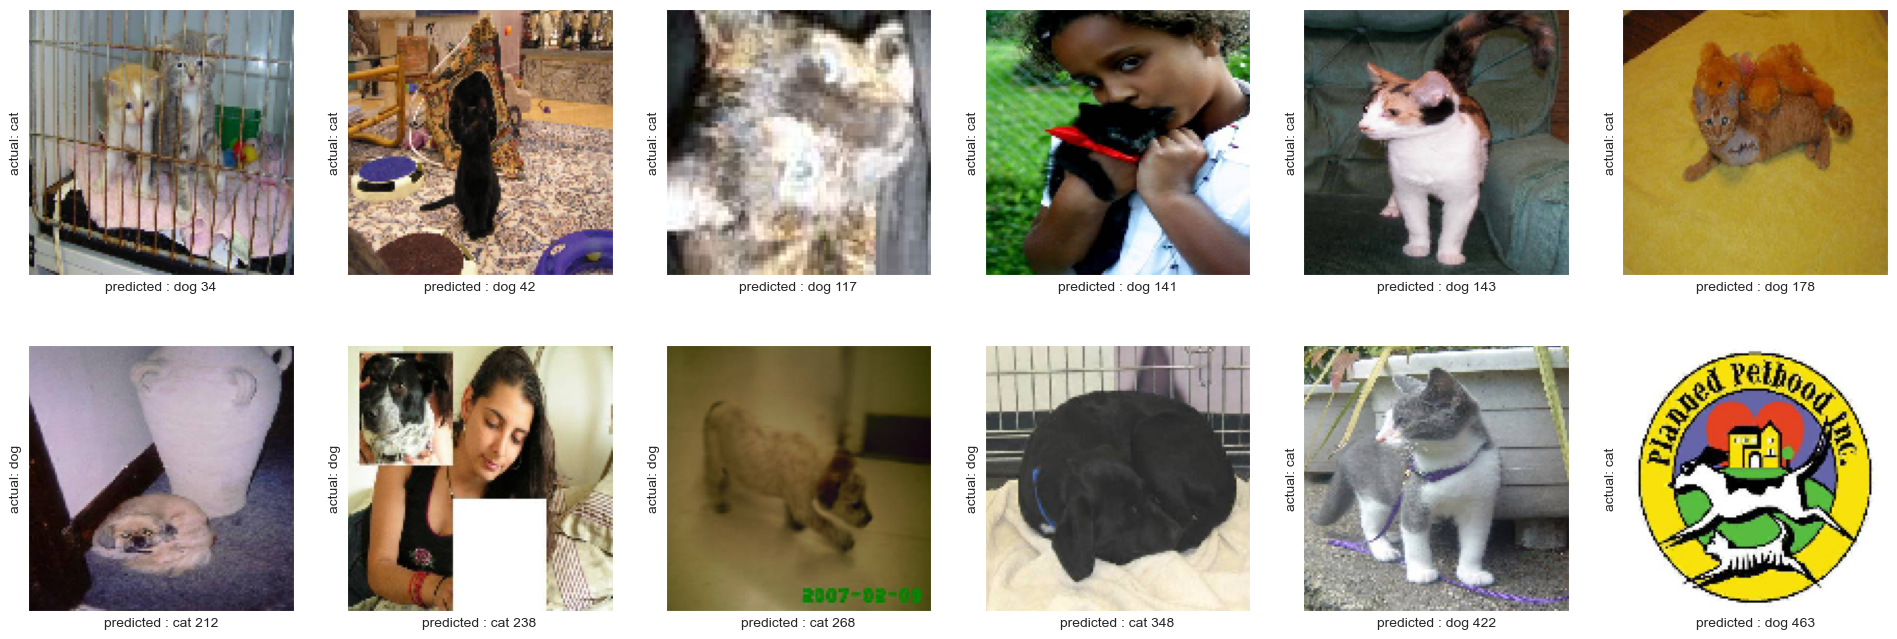

In [126]:

#Boolean of misclassified , True = misclassified
B = (y_pred_res!=y_true)
miscl_res = np.where(B)
miscl_res = miscl_res[0]

#Getting Batch id and Imno in Batch
batchid_res = []
for x in miscl_res : 
  i = int(x/batch_size)
  n = x%batch_size
  batchid_res.append((i,n,x)) 

fig = plt.gcf()
fig.set_size_inches(6 * 4, 2 * 4)

for i, mis in enumerate(batchid_res):
    batch = mis[0]
    imno = mis[1]
    idx = mis[2]
    image = test_generator[batch][0][imno]
    aclabel = labeldic[y_true[idx]]
    prelabel = labeldic[y_pred_res[idx]]
    ax = plt.subplot(2,6,i+1)
    plotmis(image,aclabel,prelabel,idx)
    if i > 10:
        break

We can see that unclear images, logos, images with more than one cat or humans, cats with collar-like objects, ever enigmatic black cats were misclassified. 

## Conclusion
For the enjoyable task of classifying images of dogs and cats, we developed a CNN model, employed hyperparameter tuning and finally we used transfer learning with ResNet.

Our ResNet based model performed the best, as expected, since ResNet is trained on more than a million images already, which gives our model a great headstart. A great learning point was that using a pre-trained model can boost performance dramatically from the start. 

Our CNN model performed quite well as well, indicating that these kind of image classification tasks are no longer a viable option for CAPTCHA.

For hyperparameter tuning, increased number of trials and epochs can be tried to get to better hyperparameters. However since transfer learning performed very well from the get go, it would be better to concentrate efforts of improvement on transfer learning models. 

For future improvement, other transfer learning models such as Xception, Inception or DenseNet can be tried out. 

Overall this was a great learning experience of image classification using CNN and transfer learning methods while working with a fun data set. 

### References
* https://www.geeksforgeeks.org/introduction-convolution-neural-network/
* https://medium.com/swlh/resnet-with-tensorflow-transfer-learning-13ff0773cf0c
* https://medium.com/@devamsheth20/how-to-plot-misclassified-images-of-your-image-classification-model-8d464e15d6d7
* https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f